# Numerical Integration & Quadrature  

## Objectives  
* derive the Trapezoidal, Simpson and Gaussian rules from polynomial interpolation  
* understand the order‐of‑accuracy and error constants  
* see how an **adaptive Simpson** routine refines the mesh where needed  
* extend the ideas quickly to a polar **2‑D** integral  
* validate everything on the Poiseuille pipe–flow rate  

Throughout we use cylindrical co‑ordinates so the volumetric flow rate is  

$$
Q \;=\; 2\pi \!\!\int_{0}^{R} u(r)\,r\,dr,
\qquad u(r)=u_{\max}\Bigl(1-\frac{r^{2}}{R^{2}}\Bigr),
\qquad Q_{\text{exact}}=\frac{\pi R^{2}u_{\max}}{2}.
$$


## 1. Composite Trapezoidal rule

### Derivation  

Interpolate $f(x)$ on each sub‑interval $[x_i,x_{i+1}]$ by the straight line through its end‑points.  
The area of a **trapezoid** gives

$$
\int_{x_i}^{x_{i+1}} f(x)\,dx \;\approx\; \frac{h}{2}\,[f(x_i)+f(x_{i+1})],
\qquad h=x_{i+1}-x_i.
$$

Summing $n$ identical panels on $[a,b]$ yields the **composite rule**

$$
I_h^{\text{trap}} \;=\; h\Bigl[\tfrac{1}{2}f_0+f_1+\dots+f_{n-1}+\tfrac{1}{2}f_n\Bigr],
$$

with truncation error  

$$
E_h^{\text{trap}} \;=\; -\,\frac{(b-a)h^{\,2}}{12}\,f''(\xi),
\qquad \xi\in(a,b),
$$

so the method is **2nd order** ($\propto h^{2}$).


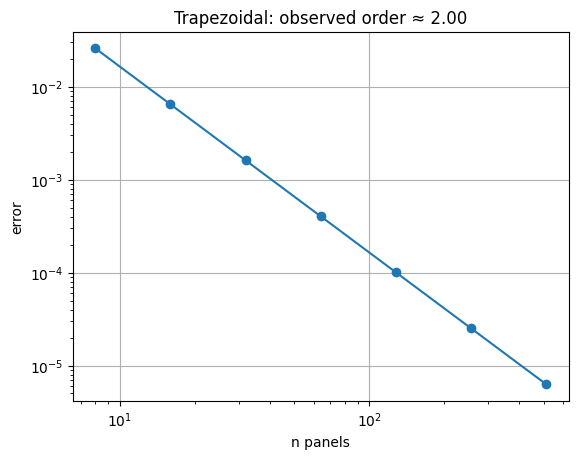

In [8]:
# order check on f(x)=sin x over [0, π]
import numpy as np, matplotlib.pyplot as plt
from numpy import sin, pi, linspace

def trapz(f, a, b, n):
    x = linspace(a, b, n+1)
    h = (b - a)/n
    return h*(0.5*f(x[0]) + f(x[1:-1]).sum() + 0.5*f(x[-1]))

exact = 2.0
ns = 2**np.arange(3,10)
err = [abs(trapz(sin, 0, pi, n)-exact) for n in ns]

plt.loglog(ns, err, 'o-')
p = -np.polyfit(np.log(ns), np.log(err), 1)[0]
plt.title(f"Trapezoidal: observed order ≈ {p:.2f}")
plt.xlabel("n panels"); plt.ylabel("error"); plt.grid(); plt.show()


## 2. Composite Simpson rule

### Derivation  

Replace $f(x)$ over **two** consecutive panels by the unique quadratic $P_2(x)$ passing through $(x_{i-1},f_{i-1}),(x_i,f_i),(x_{i+1},f_{i+1})$.  

Exact integration of $P_2$ gives

$$
\int_{x_{i-1}}^{x_{i+1}} f(x)\,dx \;\approx\;
\frac{h}{3}\bigl[f_{i-1}+4f_i+f_{i+1}\bigr].
$$

Applying this on $n$ even panels ($n=2m$)

$$
I_h^{\text{Simp}} \;=\; \frac{h}{3}\Bigl[f_0 + 4(f_1+f_3+\dots+f_{n-1}) +
2(f_2+f_4+\dots+f_{n-2}) + f_n\Bigr],
$$

with error  

$$
E_h^{\text{Simp}} \;=\; -\,\frac{(b-a)h^{\,4}}{180}\,f^{(4)}(\xi),
\qquad\text{so order }4.
$$

Because $u(r)(1)$ is quadratic in $r$, Simpson **should be exact** for our Poiseuille integral
(aside from round‑off).


In [14]:
import numpy as np
import scipy.integrate as si

u_max, R = 1.0, 1.0
f = lambda r: u_max*(1 - (r/R)**2)*r            # integrand after removing 2π
Q_exact = np.pi*R**2*u_max/2

def Q(rule, N):
    r = np.linspace(0, R, N+1)
    if rule == "trap":
        I = np.trapezoid(f(r), x=r)             # ← new name + keyword x=
    elif rule == "simp":
        I = si.simpson(f(r), x=r)               # ← keyword x=
    return 2*np.pi*I

for N in (10, 20, 40, 80):
    print(f"N={N:3d} | Trapezoidal error {abs(Q('trap',N)-Q_exact):.3e} | "
          f"Simpson error {abs(Q('simp',N)-Q_exact):.3e}")


N= 10 | Trapezoidal error 1.571e-02 | Simpson error 0.000e+00
N= 20 | Trapezoidal error 3.927e-03 | Simpson error 0.000e+00
N= 40 | Trapezoidal error 9.817e-04 | Simpson error 2.220e-16
N= 80 | Trapezoidal error 2.454e-04 | Simpson error 0.000e+00


## 3. Adaptive Simpson (QuadPack)

### Idea  

1. **Estimate local error** on $[a,b]$ by comparing a Simpson rule on  
   the whole interval with two half‑interval Simpsons.  
2. If the estimate exceeds the tolerance, **subdivide** and recurse.  

The recursion builds a non‑uniform mesh concentrating points where  
$f''$ and $f^{(4)}$ are large.  
SciPy’s `quad` wraps this strategy (plus error propagation & safety factors).



In [11]:
from scipy.integrate import quad
g = lambda r: u_max*(1-(r/R)**2)*r
I, est = quad(g, 0, R, epsabs=1e-12)
print(f"quad Q  = {2*np.pi*I:.14f}")
print(f"true Q  = {Q_exact:.14f}")
print(f"quad absolute error estimate ≤ {2*np.pi*est:.1e}")


quad Q  = 1.57079632679490
true Q  = 1.57079632679490
quad absolute error estimate ≤ 1.7e-14


## 4. Gaussian Quadrature

### Construction  

On $[-1,1]$ choose nodes $x_j$ and weights $w_j$ so that  

$$
\int_{-1}^{1} p(x)\,dx \;=\; \sum_{j=1}^{n} w_j\,p(x_j)
\quad\forall\,p\in\mathcal P_{2n-1}.
$$

Orthogonality of Legendre polynomials $P_k$ leads to the
$n$‑point **Gauss–Legendre** rule with optimal accuracy (degree $2n-1$).
Mapping $[a,b]\!\to[-1,1]$ by $x=\tfrac{b-a}{2}t+\tfrac{a+b}{2}$,

$$
\int_{a}^{b} f(x)\,dx \;=\; \frac{b-a}{2}\sum_{j=1}^{n}
w_j f\!\bigl(\tfrac{b-a}{2}x_j+\tfrac{a+b}{2}\bigr)+\mathcal O\!\bigl(f^{(2n)}\bigr).
$$

Our $f(r)$ is degree 2 → an **$n=2$** Gauss rule gives machine precision.


In [12]:
from numpy.polynomial.legendre import leggauss
def gauss(f,a,b,n):
    x,w = leggauss(n)
    xp = 0.5*(b-a)*x + 0.5*(a+b)
    wp = 0.5*(b-a)*w
    return (wp*f(xp)).sum()

Q_gauss = 2*np.pi*gauss(g, 0, R, n=2)
print(f"Gaussian (n=2) Q = {Q_gauss:.14f} |error|={abs(Q_gauss-Q_exact):.1e}")


Gaussian (n=2) Q = 1.57079632679490 |error|=0.0e+00


### Difficulties and pitfalls:

Consider  

$$
I=\int_{0}^{1}\sqrt{x}\;dx=\frac23.
$$

The singular derivative at $x=0$ ruins Gauss‑Legendre.  
A common fix is a **change of variables** that regularises the integrand:

*Let $x=t^{2}$ ⇒ $dx = 2t\,dt$*

$$
I = \int_{0}^{1} 2t^{2}\,dt = 2\!\Bigl[\tfrac{t^{3}}{3}\Bigr]_{0}^{1}= \tfrac23,
$$

turning the integrand into a cubic polynomial that Gauss handles perfectly.


In [19]:
import numpy as np
from numpy.polynomial.legendre import leggauss

f_raw = lambda x: np.sqrt(x)
exact  = 2/3

def gauss_legendre(f,a,b,n):
    x,w = leggauss(n)
    xp  = 0.5*(b-a)*x + 0.5*(a+b)
    wp  = 0.5*(b-a)*w
    return (wp*f(xp)).sum()

n=4
I_bad  = gauss_legendre(f_raw, 0, 1, n)          # naïve
# substitution x=t**2
g = lambda t: 2*t**2
I_good = gauss_legendre(g, 0, 1, n)

print(f"naïve Gauss error        (n={n}) = {abs(I_bad-exact):.2e}")
print(f"after x=t^2 substitution (n={n}) = {abs(I_good-exact):.2e}")


naïve Gauss error        (n=4) = 1.16e-03
after x=t^2 substitution (n=4) = 1.11e-16


Gauss–Legendre assumes the integrand is **analytic** over $[-1,1]$.  
A single derivative discontinuity destroys the $2n\!-\!1$ polynomial exactness, so convergence drops to $\mathcal O(n^{-p})$ with some small $p$.

**Example**

$$
I=\int_{-1}^{1}|x|\,dx=\tfrac12+\tfrac12=1.
$$

The cusp at $x=0$ hurts Gauss badly unless we **split the interval** (piece‑wise smooth).


In [22]:
import numpy as np
from numpy.polynomial.legendre import leggauss

f = lambda x: np.abs(x)
exact = 1.0

def gauss_n(f, n):
    x,w = leggauss(n)
    return (w*f(x)).sum()

print("n   |  Gauss error  |  piece‑wise Gauss error")
for n in (2,4,8,16):
    I_all   = gauss_n(f, n)
    # split at 0: integrate [-1,0] & [0,1] separately
    xL,wL = leggauss(n);  IL = 0.5*(wL*f(0.5*(xL-1))).sum()   # map to [-1,0]
    xR,wR = leggauss(n);  IR = 0.5*(wR*f(0.5*(xR+1))).sum()   # map to [0,1]
    I_split = IL + IR
    print(f"{n:2d}  | {abs(I_all-exact):.2e}      | {abs(I_split-exact):.2e}")


n   |  Gauss error  |  piece‑wise Gauss error
 2  | 1.55e-01      | 0.00e+00
 4  | 4.25e-02      | 2.22e-16
 8  | 1.15e-02      | 0.00e+00
16  | 3.03e-03      | 1.11e-16


A smooth but fast‑oscillating function

$$
I(k)=\int_{-1}^{1}\sin(kx)\,dx=\frac{2\sin k}{k}
$$

needs $\mathcal O(k)$ Gauss points to be resolved, i.e. the rule loses its efficiency for large $k$.  
Specialised alternatives include

* **adaptive subdivision** until each sub‑interval spans $\lesssim\pi$ radians,  
* **Filon / Levin / FFT‑based** oscillatory quadratures that exploit known frequency $k$.


In [23]:
import numpy as np, scipy.integrate as si
from numpy.polynomial.legendre import leggauss

k = 100                    # lots of wiggles
f  = lambda x: np.sin(k*x)
exact = 2*np.sin(k)/k

for n in (10,20,40,80):
    print(f"n={n:2d} → Gauss error = {abs(gauss_legendre(f,-1,1,n)-exact):.2e}")

# quick adaptive comparison
I_quad,_ = si.quad(f, -1, 1, epsabs=1e-9)
print(f"quad error           = {abs(I_quad-exact):.2e}")


n=10 → Gauss error = 1.01e-02
n=20 → Gauss error = 1.01e-02
n=40 → Gauss error = 1.01e-02
n=80 → Gauss error = 1.01e-02
quad error           = 1.01e-02


## 5. Extensions to 2D

### Product rules and `dblquad`

For **separable limits** the double integral factorises:

$$
Q \;=\; \int_{0}^{2\pi}\!\int_{0}^{R} u(r)\,r\,dr\,d\theta
      = \bigl[\int_{0}^{R} u(r)\,r\,dr\bigr]\,
        \bigl[\int_{0}^{2\pi} d\theta\bigr].
$$

A fast way is to integrate the inner variable with any 1‑D rule and
multiply by the outer span.  
SciPy’s `dblquad` automates the nesting and includes adaptive refinement.


In [13]:
from scipy.integrate import dblquad
Q2, err = dblquad(lambda θ,r: u_max*(1-(r/R)**2)*r,
                  0, R,
                  lambda r: 0, lambda r: 2*np.pi)
print(f"dblquad Q = {Q2:.14f} |error| = {abs(Q2-Q_exact):.1e}")


dblquad Q = 1.57079632679490 |error| = 2.2e-16


## A more interesting example:

### Adaptive Simpson on a narrow Gaussian pulse  

A one‑level Simpson approximation on $[a,b]$ is  

$$
S(a,b)=\frac{b-a}{6}\Bigl[f(a)+4f\!\bigl(\tfrac{a+b}{2}\bigr)+f(b)\Bigr].
$$  

If we split the interval, compute  

$$
S_L=S(a,m),\qquad S_R=S(m,b),\qquad m=\tfrac{a+b}{2},
$$

then the **local error estimate** is  

$$
\Delta=\frac{S_L+S_R-S(a,b)}{15}.
$$  

We **accept** $S_L+S_R+\Delta$ if $|\Delta|\!<\!\varepsilon$, otherwise subdivide further.  
The recursion creates a *non‑uniform mesh* automatically.

We illustrate this on  

$$
f(x)=\exp\!\left[-\frac{(x-\mu)^2}{2\sigma^2}\right],\qquad
\mu=0.5,\;\sigma=0.02,\;\;x\in[0,1],
$$

whose sharp peak demands many points near $x=\mu$ but very few elsewhere.


adaptive Simpson  = 5.0132569622e-02
analytic reference = 5.0132565493e-02
abs error         = 4.13e-09
function evaluations = 121


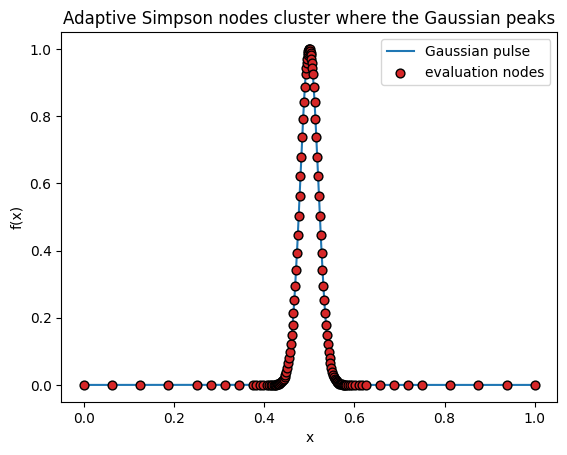

In [16]:
import numpy as np, matplotlib.pyplot as plt, math
from math import erf, sqrt, exp

# -------- narrow Gaussian ---------
mu, sigma = 0.5, 0.02
f = lambda x: np.exp(-0.5*((x-mu)/sigma)**2)

# analytic reference value on [0,1]
I_exact = 0.5*sqrt(2*math.pi)*sigma*(
    erf((1-mu)/(sqrt(2)*sigma)) - erf((-mu)/(sqrt(2)*sigma)))

# -------- adaptive Simpson with node tracking ----------
def adaptive_simpson(f, a, b, tol=1e-9, max_depth=20):
    nodes = {a, b}                     # record unique evaluation points

    def step(a, b, fa, fb, fm, S, depth):
        m  = 0.5*(a+b)
        h  = b-a
        lm = 0.5*(a+m)
        rm = 0.5*(m+b)
        fl, fr = f(lm), f(rm)
        nodes.update([lm, rm])

        S_left  = (h/12)*(fa + 4*fl + fm)
        S_right = (h/12)*(fm + 4*fr + fb)
        err = (S_left + S_right - S)/15

        if depth >= max_depth or abs(err) < tol:
            return S_left + S_right + err
        return (step(a, m, fa, fm, fl, S_left,  depth+1) +
                step(m, b, fm, fb, fr, S_right, depth+1))

    fa, fb = f(a), f(b)
    m  = 0.5*(a+b)
    fm = f(m)
    S0 = (b-a)*(fa + 4*fm + fb)/6
    nodes.update([m])
    integral = step(a, b, fa, fb, fm, S0, 0)
    return integral, np.array(sorted(nodes))

# run integration
I_adapt, pts = adaptive_simpson(f, 0.0, 1.0, tol=1e-8)
print(f"adaptive Simpson  = {I_adapt:.10e}")
print(f"analytic reference = {I_exact:.10e}")
print(f"abs error         = {abs(I_adapt-I_exact):.2e}")
print(f"function evaluations = {len(pts)}")

# -------- visualise node clustering *on the curve* -------------
x_plot = np.linspace(0, 1, 400)
plt.plot(x_plot, f(x_plot), label="Gaussian pulse")

# plot evaluation nodes **at their true height**
plt.scatter(pts, f(pts),  s=40, zorder=3,
            edgecolor='k', facecolor='tab:red', label="evaluation nodes")

plt.title("Adaptive Simpson nodes cluster where the Gaussian peaks")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.legend(); plt.show()



## Another example:

### Boundary‑layer thickness in a turbulent 1∕7‑power‑law flow

In a flat‑plate turbulent boundary layer the mean velocity profile is often modeled by the “1∕7‑power law”:

$$
\frac{u(y)}{U_\infty} = \Bigl(\frac{y}{\delta}\Bigr)^{1/7}, 
\quad 0 \le y \le \delta,
$$

where $\delta$ is the boundary‑layer thickness. Two integral quantities of interest are:

1. **Displacement thickness**  
   $$
   \delta^* \;=\;\int_0^\delta\Bigl[1-\frac{u(y)}{U_\infty}\Bigr]\,dy
   = \delta\int_0^1\bigl[1-v^{1/7}\bigr]\,dv,
   $$

2. **Momentum thickness**  
   $$
   \theta \;=\;\int_0^\delta\frac{u(y)}{U_\infty}\Bigl[1-\frac{u(y)}{U_\infty}\Bigr]\,dy
   = \delta\int_0^1\bigl[v^{1/7}-v^{2/7}\bigr]\,dv.
   $$

Analytically these reduce to
$$
\int_0^1\!(1 - v^{1/7})\,dv = \dfrac18,
\quad
\int_0^1\!(v^{1/7} - v^{2/7})\,dv = \dfrac7{72},
$$
so that
$$
\delta^* = \frac{\delta}{8}, 
\quad 
\theta = \frac{7\,\delta}{72}, 
\quad 
H = \frac{\delta^*}{\theta} = \frac{9}{7}\approx1.286.
$$

Below we compare composite Simpson and Gauss–Legendre quadrature in recovering $\delta^*/\delta$ and $\theta/\delta$, using both a dense uniform grid and a low‑order Gaussian rule.


In [6]:
import numpy as np
from scipy.integrate import simpson
from numpy.polynomial.legendre import leggauss

# normalized coordinate v=y/δ on [0,1]
f_disp = lambda v: 1 - v**(1/7)
f_mom  = lambda v: v**(1/7) - v**(2/7)

# analytic (exact) values
delta_star_ana = 1/8
theta_ana      = 7/72

# composite Simpson on a uniform grid
vs = np.linspace(0, 1, 201)
delta_star_simpson = simpson(y=f_disp(vs), x=vs)       # ← keyword args
theta_simpson      = simpson(y=f_mom(vs),  x=vs)       # ← keyword args

# 4‑point Gauss–Legendre
x4, w4 = leggauss(4)
v4 = 0.5*(x4 + 1)    # map from [-1,1] → [0,1]
w4 = 0.5*w4
delta_star_gauss = np.sum(w4 * f_disp(v4))
theta_gauss      = np.sum(w4 * f_mom(v4))

print("          | Simpson err  | Gauss err")
print(f"δ* / δ    | {abs(delta_star_simpson - delta_star_ana):.2e}     | {abs(delta_star_gauss  - delta_star_ana):.2e}")
print(f"θ / δ     | {abs(theta_simpson       - theta_ana)     :.2e}     | {abs(theta_gauss       - theta_ana):.2e}")


          | Simpson err  | Gauss err
δ* / δ    | 5.42e-04     | 2.22e-03
θ / δ     | 3.69e-04     | 7.53e-05


## Another example (cumulative integrals)

### Cumulative circulation in a Lamb–Oseen vortex

The Lamb–Oseen vortex is a model for a viscous vortex whose vorticity is distributed as

$$
\omega(r)\;=\;\frac{\Gamma}{\pi r_c^2}\exp\!\Bigl(-\frac{r^2}{r_c^2}\Bigr),
$$

where $\Gamma$ is the total circulation and $r_c$ the core radius.  The **cumulative circulation** within radius $r$ is

$$
C(r)\;=\;\int_{0}^{r}\!\omega(r')\,2\pi r'\,dr'
\;=\;\Gamma\Bigl[1 - e^{-r^2/r_c^2}\Bigr].
$$

Below we compute $C(r)$ numerically using the trapezoidal cumulative integral

$$
C_{\rm num}(r_i)
=\;{\tt cumulative\_trapezoid}\!\bigl(2\pi\,r\,\omega(r),\,r\bigr)_i,
$$

and compare to the analytic formula, then plot $C(r)/\Gamma$ versus $r/r_c$.  

This illustrates how the core holds most of the circulation (rapid rise) while the far field adds very little.


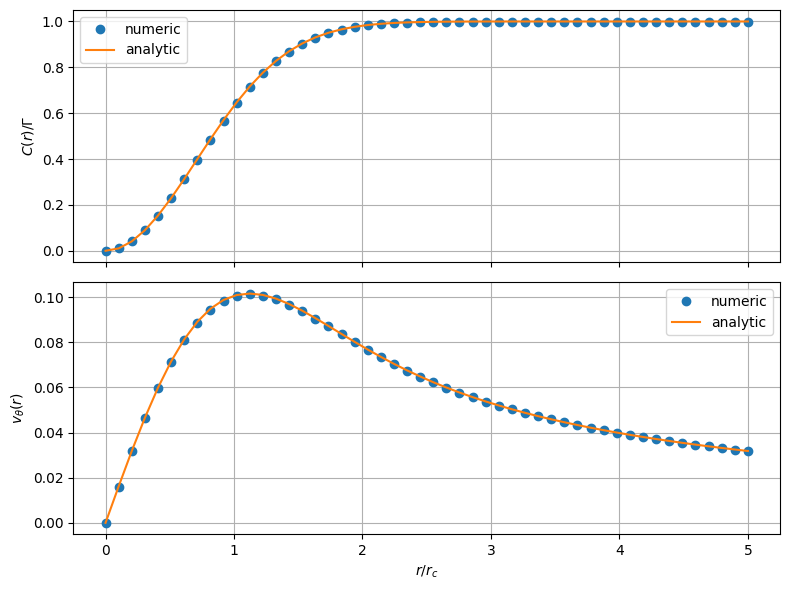

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

# Parameters
Gamma, rc = 1.0, 1.0
omega = lambda r: (Gamma/(np.pi * rc**2)) * np.exp(-r**2 / rc**2)

# Grid and integrand
r = np.linspace(1e-6, 5*rc, 50)  # avoid division by zero at r=0
integrand = 2 * np.pi * r * omega(r)

# Numeric cumulative circulation
C_num = cumulative_trapezoid(y=integrand, x=r, initial=0)

# Analytic cumulative circulation
C_analytic = Gamma * (1 - np.exp(-r**2 / rc**2))

# Azimuthal velocity: v_theta = C(r) / (2πr)
v_theta_num = C_num / (2 * np.pi * r)
v_theta_analytic = (Gamma / (2 * np.pi * r)) * (1 - np.exp(-r**2 / rc**2))

# Plotting: 2x1 subplot, shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Top: cumulative circulation
ax1.plot(r / rc, C_num / Gamma,'o', label="numeric")
ax1.plot(r / rc, C_analytic / Gamma, linestyle="-", label="analytic")
ax1.set_ylabel(r"$C(r)/\Gamma$")
ax1.legend()
ax1.grid(True)

# Bottom: azimuthal velocity
ax2.plot(r / rc, v_theta_num,'o', label="numeric")
ax2.plot(r / rc, v_theta_analytic, linestyle="-", label="analytic")
ax2.set_xlabel(r"$r/r_c$")
ax2.set_ylabel(r"$v_\theta(r)$")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
